In [28]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import poisson, halfnorm
from scipy.ndimage import gaussian_filter
from copy import copy
import multiprocessing 
import pandas as pd
from matplotlib import rc, cm
from itertools import product
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

from helper_functions import *
from data_generation import generate_diffusion_trajectory, generate_random_walk_trajectory, generatePlaceFields1D, h
from parameter_estimation import fit_diffusion_model, get_diffusion_likelihood, fit_random_walk_model_no_boundaries,\
fit_random_walk_model
from data_analysis import estimate_place_fields
from filtering_algorithms import diffusion_pf, random_walk_pf

rc('text', usetex=True)
rc('font', family='serif')

%load_ext autoreload
%autoreload 2

## Diffusion Model

### Generating Data

### Simple Diffusion Model
$$dx =  \sigma_x \times dW_t$$
$$dW_t \sim \mathcal{N} (0, dt)$$
$dt$ somewhere around $0.1-0.001$, test and check.
$$p(x_t | x_{t-dt} ) = \mathcal{N} ( x_t; x_{t-1}, \sigma_x^2 \times dt )$$

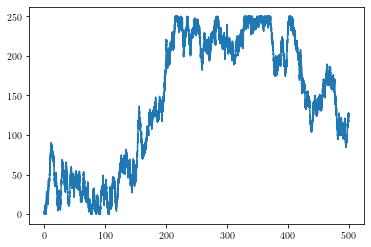

In [2]:
T = 500
dt = 0.01
t = np.arange(0,T,dt)
M = 10 # number of neurons
L = 250 # total length
dL = 0.1
P = 1000
Peff_min = 0.5

params = {
    "sigma": 10,
    "dt": dt,
#     "xaxis": xaxis, # axis for placefields
    "dL": dL,
    "T": T,
    "P": P,
    "Peff_min": Peff_min,
    "L": L
}

X, xaxis = generate_diffusion_trajectory(params)
params["xaxis"] = xaxis
        
plt.plot(t,X)
plt.show()

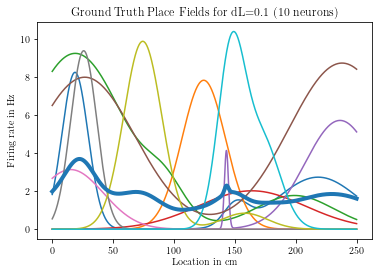

In [3]:
f = generatePlaceFields1D(M,xaxis,L)
params["f"] = f
plt.plot(xaxis,np.transpose(f))
plt.plot(xaxis,np.sum(f,0)/M,linewidth=4)
plt.title("Ground Truth Place Fields for dL={} ({} neurons)".format(dL, M))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

### Combine trajectories with spikes

In [4]:
H = h(X,f,xaxis,dL)
dN = np.random.poisson(H * dt)
spikes = dN.transpose()

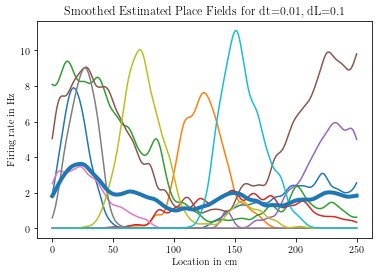

In [5]:
estimated_place_fields, smoothed_place_fields = estimate_place_fields(spikes, X, xaxis, dt, sigma=40)
plt.plot(xaxis,np.transpose(smoothed_place_fields))
plt.plot(xaxis,np.sum(smoothed_place_fields,0)/M,linewidth=4)
plt.title("Smoothed Estimated Place Fields for dt={}, dL={}".format(dt, dL))
plt.ylabel("Firing rate in Hz")
plt.xlabel("Location in cm")
plt.show()

### Split Data

In [6]:
X_train, X_validation, X_test = np.split(X, [int(.6*len(X)), int(.8*len(X))])
spikes_train, spikes_validation, spikes_test = np.split(spikes, [int(.6*len(spikes)), int(.8*len(spikes))])
estimated_place_fields, smoothed_place_fields = estimate_place_fields(spikes_train, X_train, xaxis, dt)
params["estimated_place_fields"] = estimated_place_fields
params["smoothed_place_fields"] = smoothed_place_fields

### Diffusion PF

In [7]:
x_pf, w_pf = diffusion_pf(spikes, params)

In [8]:
mu = np.sum(x_pf * w_pf, 1)
mean_validation_err = abs(mu[len(X_train):len(X_train)+len(X_validation)]-X_validation).mean()
mean_test_err = abs(mu[len(X_train)+len(X_validation):]-X_test).mean()

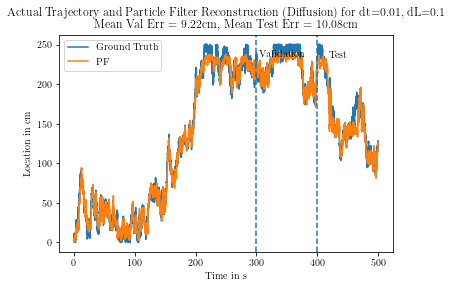

In [9]:
plt.plot(t,X)
plt.plot(t,mu)
plt.title("Actual Trajectory and Particle Filter Reconstruction (Diffusion) for dt={}, dL={}\n Mean Val Err = {:.2f}cm, Mean Test Err = {:.2f}cm".format(dt, dL, mean_validation_err, mean_test_err))
plt.legend(['Ground Truth', 'PF'])
plt.ylabel("Location in cm") 
plt.xlabel("Time in s")
plt.axvline(len(X_train) * dt, ls='--')
plt.axvline((len(X_train) + len(X_validation)) * dt, ls='--')
plt.figtext(0.59,0.8,"Validation")
plt.figtext(0.75,0.8,"Test")
plt.show()

### Parameter Variation and Estimation for Diffusion PF

In [10]:
est_sigma = fit_diffusion_model(X, dt)

In [11]:
true_sigmas = [0.01, 0.1, 0.5, 1, 2, 5, 10, 15, 20, 50, 100, 500, 1000, 5000]
predicted_true_sigma = []
for true_sigma in true_sigmas:
    params["sigma"] = true_sigma
    X, xaxis = generate_diffusion_trajectory(params)
    min_sigma = fit_diffusion_model(X, params["dt"])
    predicted_true_sigma.append(min_sigma)

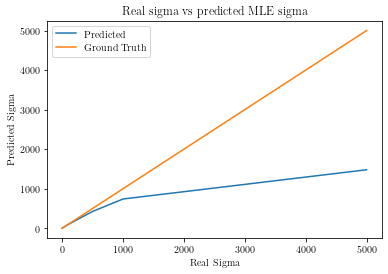

In [12]:
plt.plot(true_sigmas, predicted_true_sigma)
plt.plot(true_sigmas, true_sigmas)
plt.title("Real sigma vs predicted MLE sigma")
plt.ylabel("Predicted Sigma") 
plt.xlabel("Real Sigma")
plt.legend(['Predicted', 'Ground Truth'])

In [13]:
params["sigma"] = 10
X, xaxis = generate_diffusion_trajectory(params)
sigmas = np.sort(np.random.uniform(0, 500, 1000))
likelihoods = list(map(lambda sig: get_diffusion_likelihood(X, dt, sig), sigmas))

Text(0.5, 0, 'Sigma')

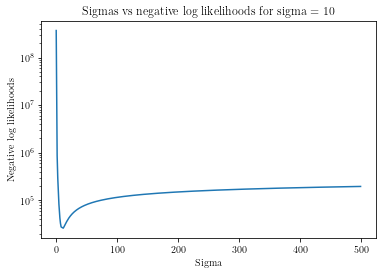

In [14]:
plt.plot(sigmas, likelihoods)
plt.title("Sigmas vs negative log likelihoods for sigma = 10")
plt.yscale('log')
plt.ylabel("Negative log likelihoods") 
plt.xlabel("Sigma")

## Testing Diffusion Model on Diffusion Data

In [15]:
true_sigma = np.random.uniform(0, 100)

params["sigma"] = true_sigma
X, xaxis = generate_diffusion_trajectory(params)
params["xaxis"] = xaxis
X_train, X_validation, X_test = np.split(X, [int(.6*len(X)), int(.8*len(X))])

sigma_hat = fit_diffusion_model(X_train, params["dt"])
params["sigma"] = sigma_hat

f = generatePlaceFields1D(M,xaxis,L)
params["f"] = f

H = h(X,f,xaxis,dL)
dN = np.random.poisson(H * dt)
spikes = dN.transpose()

spikes_train, spikes_validation, spikes_test = np.split(spikes, [int(.6*len(spikes)), int(.8*len(spikes))])
estimated_place_fields, smoothed_place_fields = estimate_place_fields(spikes_train, X_train, xaxis, dt)
params["estimated_place_fields"] = estimated_place_fields
params["smoothed_place_fields"] = smoothed_place_fields

In [16]:
x_pf, w_pf = diffusion_pf(spikes, params)

In [17]:
mu = np.sum(x_pf * w_pf, 1)
mean_validation_err = abs(mu[len(X_train):len(X_train)+len(X_validation)]-X_validation).mean()
mean_test_err = abs(mu[len(X_train)+len(X_validation):]-X_test).mean()

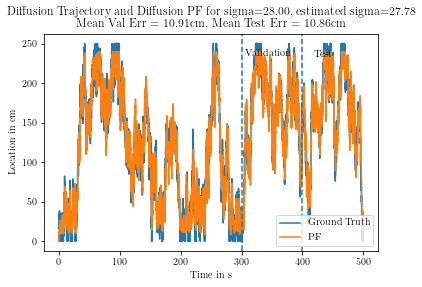

In [18]:
plt.plot(t,X)
plt.plot(t,mu)
plt.title("Diffusion Trajectory and Diffusion PF for sigma={:.2f}, estimated sigma={:.2f}\n Mean Val Err = {:.2f}cm, Mean Test Err = {:.2f}cm".format(true_sigma, sigma_hat, mean_validation_err, mean_test_err))
plt.legend(['Ground Truth', 'PF'])
plt.ylabel("Location in cm") 
plt.xlabel("Time in s")
plt.axvline(len(X_train) * dt, ls='--')
plt.axvline((len(X_train) + len(X_validation)) * dt, ls='--')
plt.figtext(0.59,0.8,"Validation")
plt.figtext(0.75,0.8,"Test")
plt.show()

## Testing IBM Model on Diffusion Data

In [19]:
q_hat, tau_hat = fit_random_walk_model_no_boundaries(X_train, dt)
params["q"] = q_hat
params["tau"] = tau_hat

/Users/kushagrasharma/coding/drugo-lab/place-cell-reconstruction/parameter_estimation.py:59: RuntimeWarning: invalid value encountered in greater
  pos = np.copy(X)


In [20]:
x_pf, w_pf = random_walk_pf(spikes, params)

/Users/kushagrasharma/coding/drugo-lab/place-cell-reconstruction/filtering_algorithms.py:86: RuntimeWarning: invalid value encountered in true_divide
  w[i] /= np.sum(w[i])


In [21]:
mu = np.sum(x_pf[:,0,:] * w_pf, 1)
mean_validation_err = abs(mu[len(X_train):len(X_train)+len(X_validation)]-X_validation).mean()
mean_test_err = abs(mu[len(X_train)+len(X_validation):]-X_test).mean()

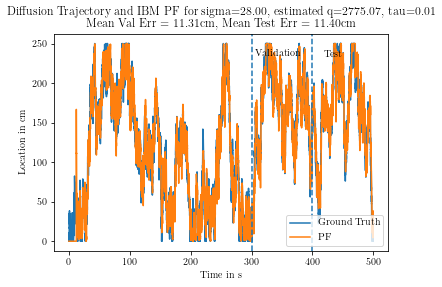

In [27]:
plt.plot(t,X)
plt.plot(t,mu)
plt.title("Diffusion Trajectory and IBM PF for sigma={:.2f}, estimated q={:.2f}, tau={:.2f}\n Mean Val Err = {:.2f}cm, Mean Test Err = {:.2f}cm".format(true_sigma, q_hat, tau_hat, mean_validation_err, mean_test_err))
plt.legend(['Ground Truth', 'PF'])
plt.ylabel("Location in cm") 
plt.xlabel("Time in s")
plt.axvline(len(X_train) * dt, ls='--')
plt.axvline((len(X_train) + len(X_validation)) * dt, ls='--')
plt.figtext(0.59,0.8,"Validation")
plt.figtext(0.75,0.8,"Test")
plt.show()

## Model Complexity

In [29]:
params["initial_condition"] = X_validation[0]
params["T"] = len(X_validation) * dt
t = np.arange(0,params["T"],dt)
params["t"] = t

In [33]:
params["P"] = 50000
x_diffusion_pf, w_diffusion_pf = diffusion_pf(spikes, params)

x_ibm_pf, w_ibm_pf = random_walk_pf(spikes, params)

In [35]:
particle_nums = np.sort(np.random.choice(np.arange(1, 50001), replace=False, size=100))
diffusion_error = []
ibm_error = []
for p_num in particle_nums:
    idx = np.sort(np.random.choice(np.arange(0, 50000), replace=False, size=p_num))
    mu_diffusion = np.sum(x_diffusion_pf[:,idx] * w_diffusion_pf[:,idx], 1)
    
    mu_ibm = np.sum(x_ibm_pf[:,0,idx] * w_ibm_pf[:,idx], 1)
                                         
    diffusion_error.append(abs(mu_diffusion - X_validation).mean())
    ibm_error.append(abs(mu_ibm - X_validation).mean())                      

KeyboardInterrupt: 

In [36]:
len(diffusion_error)

281

In [37]:
len(ibm_error)

281

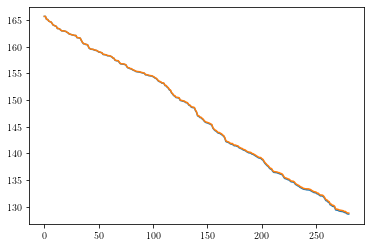

In [41]:
plt.plot(list(range(281)), diffusion_error)
plt.plot(list(range(281)), ibm_error)


In [40]:
particle_nums

13380

In [42]:
ibm_error

[165.66140367994257,
 165.65891242149686,
 165.10731211760603,
 165.10055200241084,
 164.79311351579815,
 164.6859584916111,
 164.6404286963374,
 164.3871347655898,
 164.06257118911168,
 163.96998537837104,
 163.87146969144257,
 163.78777969725775,
 163.39768500342646,
 163.39004249476557,
 163.3200206556253,
 163.106881428338,
 162.96198556762982,
 162.9646563892224,
 162.939019717238,
 162.89219479864357,
 162.83334682707596,
 162.66286115307574,
 162.56659619539332,
 162.34332919704886,
 162.3184459551305,
 162.24154359881035,
 162.19647065000407,
 162.1505704557433,
 162.09431452961428,
 162.09828641558548,
 161.70191854784642,
 161.68405179487485,
 161.64727428545896,
 161.59007253176696,
 161.17430705932426,
 160.82156511469864,
 160.54905588613718,
 160.55166674195212,
 160.42816408952547,
 160.4076365252733,
 160.28594984150158,
 159.7820976202319,
 159.62576127918243,
 159.52996196016235,
 159.52073075702125,
 159.48304105160656,
 159.38022667354136,
 159.33113071998997,
 159.

In [43]:
diffusion_error

[165.66026751509077,
 165.65490426201953,
 165.10256408765636,
 165.09623737688057,
 164.78974004382496,
 164.67967704027978,
 164.6324093356042,
 164.38220209548342,
 164.0493109473661,
 163.9645744472283,
 163.8614312226786,
 163.78212310387568,
 163.38127553376876,
 163.37996004097127,
 163.31326251511882,
 163.0992118284072,
 162.94665309093295,
 162.93738799302153,
 162.91930761271357,
 162.87442208199747,
 162.81451823242446,
 162.6493597516494,
 162.54636167321922,
 162.3309558377335,
 162.30953946481867,
 162.22733248924237,
 162.1767723448436,
 162.13330060649238,
 162.07206250132964,
 162.06670914235437,
 161.67525402659385,
 161.66161561553153,
 161.6184636406911,
 161.5698556265273,
 161.15359859082918,
 160.79252903951775,
 160.5297367929567,
 160.52263076829502,
 160.40087492893576,
 160.37653259544908,
 160.25641123095286,
 159.74122794285648,
 159.59011583532708,
 159.50565678202827,
 159.48810937328787,
 159.452460218158,
 159.3434367530329,
 159.30254023388773,
 159.2

In [44]:
idx

array([    0,    12,    13, ..., 49994, 49997, 49998])

In [45]:
len(idx)

13380

In [46]:
x_diffusion_pf[:,idx]

array([[  7.91324843,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  7.09573333,   2.78066525,   0.        , ...,   0.        ,
          0.        ,   3.69605403],
       [  9.40989808,   5.52098429,   1.77221049, ...,   1.97750628,
          0.        ,   2.29292965],
       ...,
       [182.57045389, 168.1004253 , 183.94790137, ..., 156.45323367,
        188.96762087, 176.02029808],
       [180.81764425, 163.36589437, 181.46749359, ..., 153.45755823,
        185.40856198, 178.8629896 ],
       [164.37582927, 168.61707254, 157.28248867, ..., 167.01052028,
        165.49754691, 156.31112555]])

In [47]:
x_diffusion_pf.shape

(10000, 50000)

In [48]:
X_validation.shape

(10000,)